

## <center> Polytechnique Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8008 – Prétraitement de données <br> . <br> TP3  - Échantillonnage et imputations <br>  Hiver 2025 <br> . <br> 17 février 2025 </center>

## Introduction

Le TP3 porte principalement sur l'échantillonnage et l'imputation, mais nous aborderons tout de même l'agrégation, la tabulation, le remodelage, le pivotement et les statistiques descriptives.  <b> Nous survolons l'utilisation de fonctions de base de Pandas et de l'analyse de données numériques. </b>

Dans ce travail, vous aurez à utiliser les données des deux fichiers .csv suivants :

 - <b> appointments.csv </b> : Matrice de données de 100 000 rendez-vous faits par 943 patients et portant sur 1682 docteurs;
 - <b> patients.csv </b> : Matrice de données sur les patients.

Ces données ont été générées synthétiquement par un grand modèle de langage pour approximer les interactions réelles dans le domaine des soins de santé tout en garantissant la confidentialité des données.



Voici les librairies python qui seront à utiliser pour ce TP :
- [matplotlib](https://matplotlib.org/stable/users/explain/quick_start.html)
- [numpy](https://numpy.org/doc/stable/user/basics.html)
- [pandas](https://pandas.pydata.org/docs/user_guide/index.html)





In [1]:
import pandas as pd
import numpy as np

In [2]:
df_appointments = pd.read_csv('appointments.csv')
df_patients = pd.read_csv('patients.csv')

In [3]:
df_appointments

,patient.id,doctor.id,niveau.recommandation,date
0,938,588,4,2021-01-15
1,81,1083,4,2021-11-26
2,890,1144,2,2021-05-05
3,428,18,5,2021-06-09
4,483,1130,5,2021-01-26
...,...,...,...,...
96943,351,435,4,2021-01-12
96944,187,1246,3,2021-01-05
96945,748,560,5,2021-06-16
96946,285,1429,3,2021-05-14


## Prédiction de recommendations par factorisation de matrice
<b> Mise en contexte : </b>

Un principe fondamental des systèmes de recommandations est de prédire les rendez-vous des patients aux docteurs qui n’ont pas encore de rendez-vous et sont présumés des candidats à recommander. On recommande alors les docteurs dont les rendez-vous estimés sont les plus élevés. Une méthode très facile à implémenter consiste à factoriser une matrice de rendez-vous dans un espace à dimensions réduites puis à effectuer le produit des matrices factorisées. Ce produit constitue la prédiction des rendez-vous sur la base de réduction de dimensions.

Le fichier appointments.csv contient 100 000 rendez-vous de 943 patients pour 1682 docteurs. Il faut, dans un premier temps, créer cette matrice et ensuite la factoriser en un produit de matrices dont le rang est plus petit. Mais la matrice originale contient un grand nombre de valeurs manquantes et il est nécessaire d’effectuer une imputation avant la factorisation par des méthodes analytiques, notamment la méthode de décomposition en valeurs singulières que nous utiliserons (SVD).

De plus, il faut aussi effectuer une validation croisée afin de déterminer le bon nombre dimensions pour la factorisation ainsi que s’il est préférable de faire une imputation de valeurs aléatoires, de la moyenne des lignes, ou de la moyenne des lignes et des colonnes.

### A)
Mettez les données de "df_appointments" sous la forme d'une matrice de rendez-vous patients $\times$ docteurs. <b>(1.5 points)</b>

Pour ce faire:
1. Retirez la colonne "date" du DataFrame "df_appointments".
2. Triez les données par "patient.id" et "doctor.id".
3. Regroupez les données par "patient.id" et faites l'agrégation des "niveau.recommandation" pour chaque "doctor.id".
4. Convertissez en matrice.

Affichez les dimensions de la matrice, celle-ci devrait être de "shape" (943, 1682).

In [60]:
# Retirer la colonne "date"
df_app_sans_date = df_appointments.drop(columns=["date"])

# Trier les données par "patient.id" et "doctor.id"
df_app_trie = df_app_sans_date.sort_values(by=["patient.id", "doctor.id"])

# Regrouper les données et convertir en matrice
R = df_app_trie.pivot_table(
    index="patient.id", 
    columns="doctor.id", 
    values="niveau.recommandation"
)

# Afficher les dimensions de la matrice
print("Dimensions de la matrice:", R.shape)

Dimensions de la matrice: (943, 1682)



### B)
Pour factoriser une matrice, elle ne doit contenir aucune valeur manquante.  Imputez (remplacez) les valeurs manquantes (valeurs non observées) dans la matrice créée précédemment selon les trois méthodes suivantes : <b>(2.5 points)</b>  
1. Remplacer les "nan" par des valeurs aléatoires d'une distribution normale (0,1).
2. Remplacer les "nan" par la moyenne des lignes.
3. Remplacer les "nan" par la moyenne des lignes et colonnes.

Affichez la matrice obtenue pour chaque méthode.



In [59]:
nan_mask = np.isnan(R.values)
valeursObservees = ~np.isnan(R.values)

# Méthode 1: Remplacer par des valeurs aléatoires d'une distribution Normale (0,1)
R_method1 = R.copy()
random_values = np.random.normal(0, 1, size=R.shape)
R_method1_values = R_method1.values
R_method1_values[nan_mask] = random_values[nan_mask]
R_method1 = pd.DataFrame(R_method1_values, index=R.index, columns=R.columns)
print("Méthode 1: \n", R_method1.iloc[:5, :5])  # Affichage partiel pour lisibilité

# Méthode 2: Remplacer par la moyenne des lignes
R_method2 = R.copy()
row_means = np.nanmean(R.values, axis=1)
R_method2_values = R_method2.values
for i, mean in enumerate(row_means):
    R_method2_values[i, nan_mask[i, :]] = mean
R_method2 = pd.DataFrame(R_method2_values, index=R.index, columns=R.columns)
print("Méthode 2: \n", R_method2.iloc[:5, :5])  # Affichage partiel pour lisibilité

# Méthode 3: Remplacer par la moyenne des lignes et colonnes
R_method3 = R.copy()
R_values = R.values
row_means = np.nanmean(R_values, axis=1).reshape(-1, 1)
col_means = np.nanmean(R_values, axis=0).reshape(1, -1)
global_mean = np.nanmean(R_values)

R_method3_values = R_method3.values
for i in range(R_values.shape[0]):
    for j in range(R_values.shape[1]):
        if nan_mask[i, j]:
            if not np.isnan(row_means[i]) and not np.isnan(col_means[0, j]):
                R_method3_values[i, j] = (row_means[i] + col_means[0, j]) / 2
            elif not np.isnan(row_means[i]):
                R_method3_values[i, j] = row_means[i]
            elif not np.isnan(col_means[0, j]):
                R_method3_values[i, j] = col_means[0, j]
            else:
                R_method3_values[i, j] = global_mean

R_method3 = pd.DataFrame(R_method3_values, index=R.index, columns=R.columns)
print("Méthode 3: \n", R_method3.iloc[:5, :5])  # Affichage partiel pour lisibilité

Méthode 1: 
 doctor.id          1         2         3         4         5
patient.id                                                  
1           0.310248  5.000000 -0.367821 -0.776631  2.000000
2           1.837024 -1.500075 -1.175135  0.526934  0.582942
3           1.000000 -0.891187  2.000000  0.338592  0.810296
4           5.000000  0.468435 -1.477461  1.315567  0.600257
5           0.847673 -0.250074  0.595617  0.177595 -0.136482
Méthode 2: 
 doctor.id          1         2         3         4         5
patient.id                                                  
1           3.351852  5.000000  3.351852  3.351852  2.000000
2           2.784314  2.784314  2.784314  2.784314  2.784314
3           1.000000  2.708738  2.000000  2.708738  2.708738
4           5.000000  3.086538  3.086538  3.086538  3.086538
5           2.744444  2.744444  2.744444  2.744444  2.744444


C:\Users\omarb\AppData\Local\Temp\ipykernel_44280\2259394830.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R_method3_values[i, j] = (row_means[i] + col_means[0, j]) / 2


Méthode 3: 
 doctor.id          1         2         3         4         5
patient.id                                                  
1           3.339562  5.000000  3.025926  3.229980  2.000000
2           3.055793  2.682157  2.742157  2.946211  2.979876
3           1.000000  2.644369  2.000000  2.908423  2.942088
4           5.000000  2.833269  2.893269  3.097323  3.130989
5           3.035859  2.662222  2.722222  2.926276  2.959942


### C)

<b> Mise en contexte: </b>

Il faut maintenant effectuer une validation croisée à 5 replis en échantillonnant aléatoirement 5 ensembles de rendez-vous parmi les 100 000 rendez-vous observés qui serviront tour à tour d’ensemble de test, les autres étant utilisées pour l’entraînement (estimation des matrices de factorisation).

Pour ce faire, utilisez la fonction <code>validation_croisee_replis()</code> qui effectue une validation croisée par replis de la factorisation SVD et retourne l’erreur quadratique moyenne. Elle utilise une matrice, <code>echantillonReplis</code>, dont chaque ligne contient l’indice des observations de test pour chaque "replis" et qui est créée plus loin.

Utilisez la variable <code>valeurs_observees</code> (obtenue à l'aide de la matrice créer dans la partie "A" ci-dessus) et la fonction <code>random.choice()</code> de numpy.

Affichez les dimensions de l'échantillon, vous devriez avoir (5, 19389). <b> (1 point) </b>


In [58]:
from validation_croisee import validation_croisee_replis, validation_croisee

In [61]:

# Paramètres pour la validation croisée
n_dimensions = 14
nombre_replis = 5
valeurs_observees = ~np.isnan(R)

# Préparation des indices des valeurs observées dans R
indices_observes = np.where(valeurs_observees)
indices_combinés = np.column_stack(indices_observes)
total_observations = len(indices_combinés)

# Mélanger les indices (on utilise ici np.random.shuffle)
np.random.shuffle(indices_combinés)

# Calculer la taille de chaque repli
taille_repli = total_observations // nombre_replis
taille_max_repli = taille_repli + (total_observations % nombre_replis)

# Créer la matrice echantillonReplis
echantillonReplis = np.full((nombre_replis, taille_max_repli), -1, dtype=int)

for i in range(nombre_replis):
    debut = i * taille_repli
    fin = (i + 1) * taille_repli if i < nombre_replis - 1 else total_observations
    fold_indices = indices_combinés[debut:fin]
    flat_indices = np.ravel_multi_index((fold_indices[:, 0], fold_indices[:, 1]), dims=R.shape)
    echantillonReplis[i, :len(flat_indices)] = flat_indices

print("Dimensions of echantillonReplis:", echantillonReplis.shape)

Dimensions of echantillonReplis: (5, 19392)


### D)

Pour chacune des 3 méthodes d'imputation utilisées précédemment, affichez le résultat de la validation croisée. <b> (0.5 point) </b>

Les résultats qui seront affichés pour chaque méthode devraient être similaire à ceux-ci:
1. Méthode 1 : array([3.07936543 2.97096366 3.00239858 2.98364498 3.07552508]).

2. Méthode 2 : array([1.35600187 1.36579327 1.37056779 1.35480193 1.3561739]).

3. Méthode 3 : array([1.34846446 1.36657222 1.3627661  1.3456932  1.34794998]).


In [62]:
method1_results = validation_croisee_replis(
    R_values, 
    R_method1_values, 
    echantillonReplis, 
    valeurs_observees, 
    n_dimensions
)

In [63]:
method2_results = validation_croisee_replis(
    R_values, 
    R_method2_values, 
    echantillonReplis, 
    valeurs_observees, 
    n_dimensions
)

In [64]:
method3_results = validation_croisee_replis(
    R_values, 
    R_method3_values, 
    echantillonReplis, 
    valeurs_observees, 
    n_dimensions
)

In [65]:
print ("Méthode 1 : ")
print(method1_results)
print ("Méthode 2 : ")
print(method2_results)
print ("Méthode 3 : ")
print(method3_results)

Méthode 1 : 
[3.0243388  3.03510304 3.02472443 3.02918287 3.03296541]
Méthode 2 : 
[1.35921342 1.35504515 1.34793269 1.35193028 1.35193927]
Méthode 3 : 
[1.35261568 1.34904603 1.34201558 1.34577679 1.34583966]


Affichez les résultats de la validation croisée pour chaque méthode (Méthode 1, Méthode 2, Méthode 3) sur un seul graphique en boîte à moustaches (boxplot). <b> (2 points) </b>

C:\Users\omarb\AppData\Local\Temp\ipykernel_44280\1063870985.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


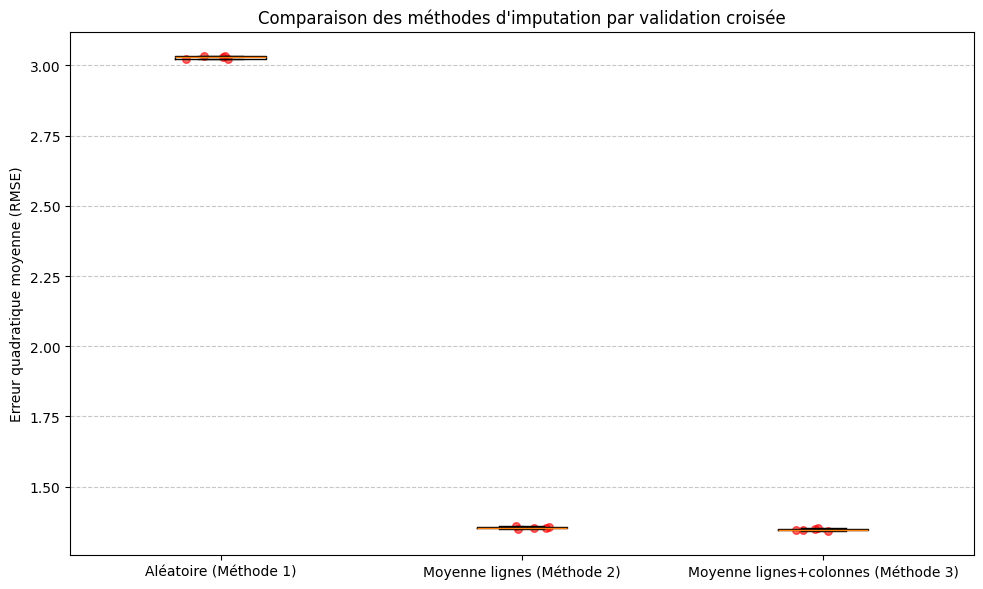

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
data = [method1_results, method2_results, method3_results]
labels = ['Aléatoire (Méthode 1)', 'Moyenne lignes (Méthode 2)', 'Moyenne lignes+colonnes (Méthode 3)']

plt.boxplot(data, labels=labels)
plt.title('Comparaison des méthodes d\'imputation par validation croisée')
plt.ylabel('Erreur quadratique moyenne (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajout des points individuels pour mieux visualiser la distribution
for i, results in enumerate(data):
    # Ajouter un peu de bruit horizontal pour mieux voir les points
    x = np.random.normal(i+1, 0.05, size=len(results))
    plt.scatter(x, results, alpha=0.6, color='red', s=30)

plt.tight_layout()
plt.show()

### E)
Explorez le nombre de dimensions qui est optimal par visualisation de la performance prédictive en fonction du nombre de dimensions. Prenez la moyenne par ligne et colonne comme imputation et cet ensemble de dimensions à explorer : (2, 4, 8, 10, 15, 20, 40). N’utilisez qu’un échantillon de données.  <b>(1 point)</b>

Pour ce faire:
1. Calculez l'erreur quadratique pour chaque dimension.
2. Affichez dans un graphique l'erreur quadratique selon le nombre de dimensions.

*Note: Le graphique doit utiliser des marqueurs de type 'o' et un style de ligne '-'. N'oubliez pas de nommer les axes et de donner un titre.*



In [ ]:
import matplotlib.pyplot as plt

Dimensions: 2, RMSE: 1.4050
Dimensions: 4, RMSE: 1.3956
Dimensions: 8, RMSE: 1.3781
Dimensions: 10, RMSE: 1.3692
Dimensions: 15, RMSE: 1.3483
Dimensions: 20, RMSE: 1.3279
Dimensions: 40, RMSE: 1.2513


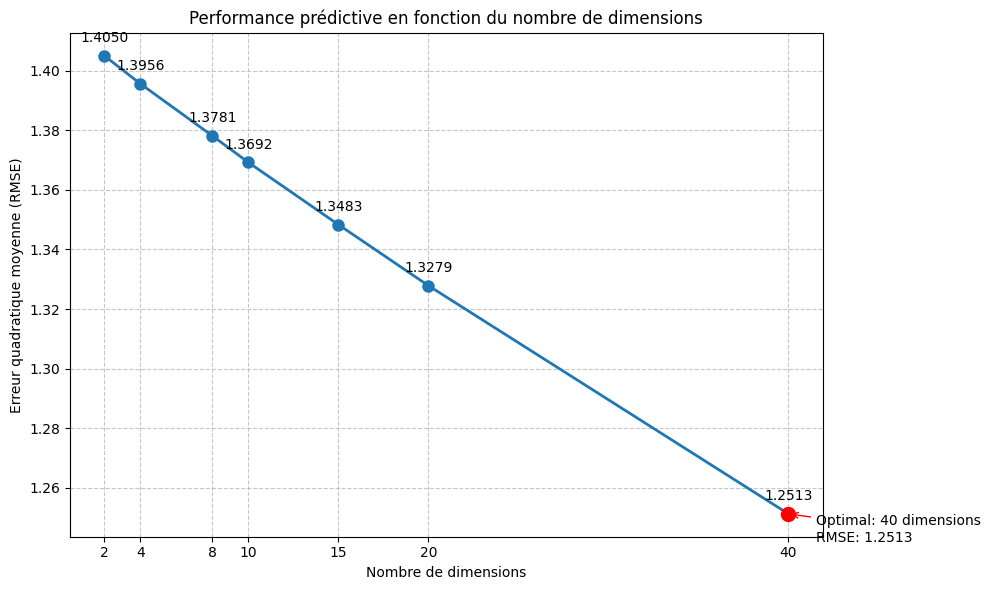

In [68]:
# Utiliser la méthode 3 (moyenne des lignes et colonnes) qui semble donner les meilleurs résultats
dimensions_a_explorer = [2, 4, 8, 10, 15, 20, 40]
rmse_par_dimension = []

# Pour réduire le temps de calcul, utilisons seulement le premier repli
sample_test_indices = echantillonReplis[0]

for dim in dimensions_a_explorer:
    # Calcul de l'erreur quadratique pour cette dimension
    rmse = validation_croisee(
        R_values, 
        R_method3_values, 
        sample_test_indices, 
        valeurs_observees, 
        dim
    )
    rmse_par_dimension.append(rmse)
    print(f"Dimensions: {dim}, RMSE: {rmse:.4f}")

# Affichage graphique de l'erreur selon le nombre de dimensions
plt.figure(figsize=(10, 6))
plt.plot(dimensions_a_explorer, rmse_par_dimension, 'o-', linewidth=2, markersize=8)
plt.xlabel('Nombre de dimensions')
plt.ylabel('Erreur quadratique moyenne (RMSE)')
plt.title('Performance prédictive en fonction du nombre de dimensions')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(dimensions_a_explorer)

# Ajouter les valeurs RMSE au-dessus des points
for i, txt in enumerate(rmse_par_dimension):
    plt.annotate(f"{txt:.4f}", 
                 (dimensions_a_explorer[i], rmse_par_dimension[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Trouver et marquer la dimension optimale
dim_optimale_index = np.argmin(rmse_par_dimension)
dim_optimale = dimensions_a_explorer[dim_optimale_index]
rmse_optimale = rmse_par_dimension[dim_optimale_index]

plt.scatter([dim_optimale], [rmse_optimale], s=100, c='red', zorder=5)
plt.annotate(f"Optimal: {dim_optimale} dimensions\nRMSE: {rmse_optimale:.4f}",
             (dim_optimale, rmse_optimale),
             textcoords="offset points", 
             xytext=(20,-20),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

## Probabilités bayésiennes

<b> Mise en contexte : </b>

La seconde approche de prédiction est basée sur les probabilités conditionnelles avec des ratios de vraisemblance. Ces calculs nécessitent des tableaux de contingences entre deux variables, la variable à prédire et le facteur de prédiction. Nous voudrons prédire si un individu est susceptible de recommender un docteur en fonction de trois variables, son sexe, son âge et sa condition de santé. Il nous faut donc créer les tableaux suivants.


### F)

Créez un tableau des données de rendez-vous et des patients.

Pour ce faire:
1. Renommez la colonne "patients.id" du DataFrame appointments par "id ".
2. Faites un left-join de nouveau DataFrame créé avec le DataFrame des patients.
3. Enlevez les colonnes "date" et " zip".
4. Ajoutez une nouvelle colonne "recommande" qui est à True si le "niveau.recommandation" est supérieur à 4.

Affichez le nouveau tableau. <b> (1 point) </b>

In [70]:
# Préparation des données pour l'analyse bayésienne
# 1. Renommer la colonne patient.id du DataFrame appointments
df_appointments_renamed = df_appointments.rename(columns={"patient.id": "id"})

# 2. Joindre avec le DataFrame des patients (left join)
df_combined = pd.merge(df_appointments_renamed, df_patients, on="id", how="left")

# 3. Supprimer les colonnes "date" et "zip" si elles existent
columns_to_drop = [col for col in ["date", "zip"] if col in df_combined.columns]
df_combined = df_combined.drop(columns=columns_to_drop)

# 4. Ajouter une colonne "recommande" (True si niveau.recommandation > 4)
df_combined["recommande"] = df_combined["niveau.recommandation"] > 4

# Afficher le nouveau tableau
print("Dimensions du tableau combiné:", df_combined.shape)
df_combined.head()

Dimensions du tableau combiné: (96948, 8)


,id,doctor.id,niveau.recommandation,age,gender,condition,zip,recommande
0,938,588,4,38,M,Asthma,55038,False
1,81,1083,4,70,M,Hypertension,21218,False
2,890,1144,2,62,F,Asthma,97301,False
3,428,18,5,56,F,Hypertension,55414,True
4,483,1130,5,27,M,Healthy,43212,True


### G)

Créez un nouveau tableau "recommande_gender" qui présente la proportion de patients qui recommande ou qui ne recommande pas un docteur.

Pour ce faire :
1. À partir du DataFrame "appointments", regroupez les données par "doctor.id" et par "gender".
2. Appliquez la fonction "recommande_tbl" sur la colonne "recommande" et réinitialisez l'index.
3. Créez un "pivot table" dont l'index est "doctor.id", la colonne est " gender ", les valeurs sont "recommande" et "recommandePas", puis utilisez la sommation comme fonction d'agrégation.
4. Créez une colonne "LS" à l'aide de la fonction "ratio_vraisemblance" qui contient le résultat du ratio de vraisemblance. Voici les paramètres à donner à cette fonction :
  - EH:  recommande_gender[('recommande', 'F')]
  - EnH: recommande_gender[('recommandePas', 'F')]
  - nEH: recommande_gender[('recommande', 'M')]
  - nEnH: recommande_gender[('recommandePas', 'M')]

*Note: La valeur LS de votre 1ère ligne devrait être environ 1.147059.*

Affichez le nouveau DataFrame. <b> (1 point) </b>


In [72]:
def recommande_tbl(x):
    return pd.DataFrame({'recommande': [sum(x)], 'recommandePas': [sum(1-x)]})

def ratio_vraisemblance(EH, EnH, nEH, nEnH):
    return ((EH+1)/(EH+nEH+2))/((EnH+1)/(EnH+nEnH+2))

In [73]:
# Création du tableau recommande_gender
# 1. Regrouper par doctor.id et gender
recommande_gender = df_combined.groupby(["doctor.id", "gender"])["recommande"].apply(recommande_tbl).reset_index()

# 2. Pivoter le tableau
recommande_gender = recommande_gender.pivot_table(
    index="doctor.id",
    columns="gender",
    values=["recommande", "recommandePas"],
    aggfunc="sum"
)

# 3. Calculer le ratio de vraisemblance (LS)
recommande_gender["LS"] = ratio_vraisemblance(
    EH=recommande_gender[("recommande", "F")],
    EnH=recommande_gender[("recommandePas", "F")],
    nEH=recommande_gender[("recommande", "M")],
    nEnH=recommande_gender[("recommandePas", "M")]
)

# Vérifier la première valeur LS
print(f"Première valeur LS: {recommande_gender['LS'].iloc[0]:.6f}")

# Afficher le tableau
recommande_gender.head()

Première valeur LS: 1.147059


recommande     recommandePas            LS
gender             F   M             F   M          
doctor.id                                           
1                  9   9            16  21  1.147059
2                  5   4            16  25  1.379679
3                  5   1            21  23  1.568182
4                 10   8            30  26  1.029032
5                  3  10            25  19  0.471795

### H)
Affichez dans un graphique à barres la valeur LS pour les dix premiers "doctor.id" en utilisant le tableau "recommande_gender". <b> (0.5 point) </b>

*Note: N'oubliez pas de nommer vos axes et votre graphique.*

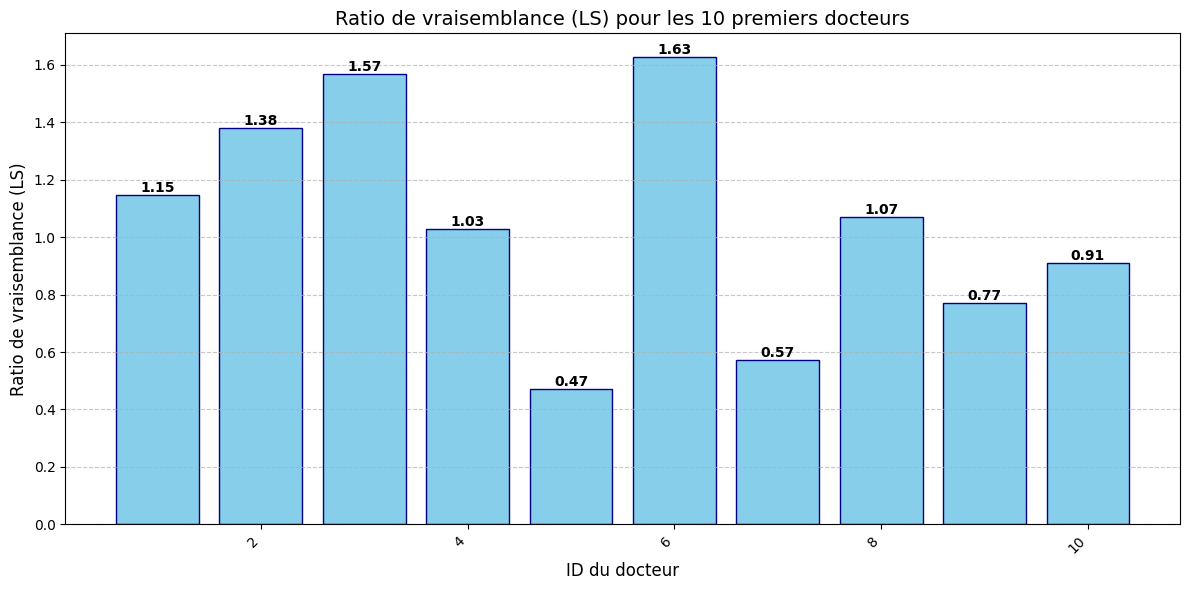

In [74]:
# Création du graphique à barres pour les 10 premiers docteurs
plt.figure(figsize=(12, 6))

# Extraire les 10 premiers doctors.id et leurs valeurs LS
top_10_doctors = recommande_gender["LS"].head(10)
doctors_ids = top_10_doctors.index

# Créer le graphique à barres
bars = plt.bar(doctors_ids, top_10_doctors, color='skyblue', edgecolor='navy')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold')

# Ajouter les titres et les étiquettes
plt.title('Ratio de vraisemblance (LS) pour les 10 premiers docteurs', fontsize=14)
plt.xlabel('ID du docteur', fontsize=12)
plt.ylabel('Ratio de vraisemblance (LS)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

## 3. LIVRABLES
Vous devez remettre sur Moodle un fichier compressé .zip contenant :

1) Le code : Un Jupyter notebook en Python qui contient le code tel implanté avec les librairies minimales demandées pour ce TP (Python, Pandas, Matplotlib). Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière. Tous vos résultats doivent être reproductibles avec le code dans le notebook. *Attention, en aucun cas votre code ne doit avoir été copié de d'ailleurs.*

2) Un fichier pdf représentant votre notebook complètement exécuté sous format pdf (obtenu via latex ou imprimé en pdf avec le navigateur). Assurez-vous que le PDF est entièrement lisible. [Tutoriel youtube](https://www.youtube.com/watch?v=-Ti9Mm21uVc)

ATTENTION: assurez-vous que votre fichier compressé .zip ne dépasse pas la taille limite acceptée sur Moodle.


__ÉVALUATION__ <br>
Votre TP sera évalué sur les points suivants :

__Critères :__
1. Implantation correcte et efficace
2. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.) <b>(1 point)</b>
3. Réponses correctes/sensées aux questions de réflexion ou d'analyse

__CODE D’HONNEUR__
- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. Vous __ne pouvez pas__ soumettre un code, écrit par quelqu’un d’autre. Dans le cas contraire, cela sera considéré comme du plagiat.
- __Règle 2__: Vous êtes libres de discuter avec d'autres équipes. Cependant, vous ne pouvez en aucun cas incorporer leur code dans votre TP.
- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement.

### Conversion en PDF sur Google Colab

In [ ]:
%%capture
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Assurez vous d'avoir téléchargé le TP complété en notebook sur votre ordinateur, puis importé ce fichier dans le répertoire "content" avant de rouler la ligne suivante.

In [ ]:
!jupyter nbconvert --to pdf /content/TP1.ipynb